In [1]:
#This is a copy of gsw.py at the time of writing except with some modifications in next_direction

import numpy as np
from itertools import compress
import random
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (16, 20)
from mpl_toolkits.mplot3d import Axes3D 
import tikzplotlib
from itertools import chain, combinations
import pickle
import sys
import sklearn.linear_model as sklm
import quadprog
import functools
import time
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
float_formatter = "{:.3e}".format
#np.set_printoptions(formatter={'float_kind':float_formatter})
#plt.rcParams.update({'font.size': 22})

def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

def get_alives(x,a,b,basis,previous=None,thresh=1e-12,debug=False):
    if debug:
        print(f'Computing the list of elements that are alive with threshold {thresh}')
        print(f'x in basis: {x}')
        print(f'a: {a}')
        print(f'b: {b}')
    if sum((x-a)>-thresh)<len(x) or sum((b-x)>-thresh)<len(x):
        x[((x-a)<-thresh) | ((b-x)<-thresh)]=np.round(x[((x-a)<-thresh) | ((b-x)<-thresh)])
        if sum((x-a)>-thresh)<len(x) or sum((b-x)>-thresh)<len(x):
            print('Issue: x is out of bound!')
            debug=True
    alive=(np.abs(x-a)>thresh) & (np.abs(x-b)>thresh)
    #alive=np.array([-1<x[i]<1 for i in range(len(x))])
    return alive,debug,None if previous is None else [i for i in range(len(alive)) if ((previous[i]) and not alive[i])]

def choose_pivot(v,x,alive,mode='random',debug=False):
    if debug:
        print(f'Choosing pivot through mode {mode}.')
        print(f'x in basis: {x}')
        print(f'Alive: {alive}')
    if mode=='max_index':
        for i in range(len(x),0,-1):
            if alive[i]:
                return i
        pivot= -1
    elif mode=='random':
        try:
            pivot= random.choice(np.arange(len(x))[alive])
        except IndexError:
            #print('Every element is fixed')
            pivot= -1
    elif mode=='max_norm':
        norms=[norm(v[i]) if alive[i] else 0 for i in range(len(v))]
        if debug:
            print(f'norms: {norms}')
        pivot= np.argmax(norms) if max(norms)!=0 else -1
    elif mode=='norm':
        norms=[norm(v[i]) if alive[i] else 0 for i in range(len(v))]
        if max(norms)!=0:
            r=random.random()*sum(norms)
            cumsum_norms=np.cumsum(norms)
            cumsum_norms[cumsum_norms-r<0]=float('Inf')
            pivot=np.argmin(cumsum_norms)
        else:
            pivot=-1
    elif mode=='coloring':
        if sum(alive)==0:
            pivot=-1
        elif max(np.abs(x[alive]))==0:
            pivot=random.choice(np.arange(len(x))[alive])
        else:
            coloring_values=np.abs(x)
            coloring_values[~alive]=0
            r=random.random()*sum(coloring_values)
            cumsum_col=np.cumsum(coloring_values)
            cumsum_col[cumsum_col-r<0]=float('Inf')
            pivot=np.argmin(cumsum_col)
    elif mode=='max_coloring':
        if sum(alive)==0:
            pivot=-1
        elif max(np.abs(x[alive]))==0:
            pivot=random.choice(np.arange(len(x))[alive])
        else:
            coloring_values=np.abs(x)
            coloring_values[~alive]=0
            pivot=np.argmax(coloring_values)
    else:
        print('Unknown mode of pivot choice: aborting.')
        pivot=None
    if debug:
        print(f'Pivot chosen: {pivot}')
    return pivot

#@timer
def next_direction(p,v,a,b,B,alive,old_alive_and_not_pivot,old_alive,X_t=None,debug=False,bigger_first=False,force_balance=False,fast_lst_sq=True,solve_adversarial=False,d_instead_of_d_inv=False,i_instead_of_d_inv=False,no_matrix_mult=True,flag_issue=False,B_S=None,C_S=None):
    u=np.zeros(len(v))
    u[p]=1
    alive_and_not_pivot=alive.copy()
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    if alive_and_not_pivot.any() and (((bigger_first or solve_adversarial) and not no_matrix_mult) or flag_issue or debug):
        q,r=np.linalg.qr(B[:,alive_and_not_pivot])
        rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
        if len(rs)!=0:
            q=q[:,~rs]
            v_perp=B[:,p]-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(B[:,p])
        else:
            v_perp=B[:,p]
    else:
        v_perp=B[:,p]
    u1=B_t.T.dot(-B[:,p])
    colinear=False
    u[alive_and_not_pivot]=u1
    if debug or (flag_issue and max(np.abs(v_perp-B.dot(u)))>1e-6 and not force_balance and not i_instead_of_d_inv and not d_instead_of_d_inv):
        #print('Issue with classic u')
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    if no_matrix_mult and (debug or (flag_issue and max(np.abs(v_perp-B.dot(u_2)))>1e-6 and not force_balance and not i_instead_of_d_inv and not d_instead_of_d_inv)):
        #print('Issue with u from no_mat_mult')
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp_2-B.dot(u_2)}')
    if debug:
        print(f'Calculated update direction u:{u}')
    return u,colinear,X_t,alive_and_not_pivot,alive,B_S,C_S

def quadprog_solve_qp(P, q, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    qp_C = -A.T
    qp_b = -b
    meq = A.shape[0]
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def next_factor(x_in_basis,u,p,a,b,colinear,debug=False,smallest_delta=False,bigger_first=False,thresh=0):
    non_zero=np.abs(u)>1e-10
    deltas=np.concatenate(((a[non_zero]-x_in_basis[non_zero])/u[non_zero],(b[non_zero]-x_in_basis[non_zero])/u[non_zero]),axis=0)
    if debug:
        print(f'All deltas considered:{deltas}')
    try:
        d_p=min(deltas[deltas>thresh])
        if debug:
            print(f'delta_+:{d_p}')
    except:
        print(f'No delta>=0: {deltas}')#could set d_p=0 maybe
    try:
        d_m=max(deltas[deltas<-thresh])
        if debug:
            print(f'delta_-:{d_m}')
    except:
        print(f'No delta<=0: {deltas}')#could set d_m=0 maybe
    if d_p<1e-12 and d_m>-1e-12:
        print('Issue: too small deltas')
    if not bigger_first or not colinear or abs(x_in_basis[p])<=thresh:
        r=random.random()
        if r>d_p/(d_p-d_m) or (smallest_delta and d_p<abs(d_m)):
            if debug:
                print('delta=delta_+')
            return d_p,d_m
        else:
            if debug:
                print('delta=delta_-')
            return d_m,d_p
    else:
        if abs(x_in_basis[p])>0:
            if debug:
                print('delta=delta_+')
            return d_p,d_m
        else:
            if debug:
                print('delta=delta_-')
            return d_m,d_p

def change_basis(v,basis1,basis2):#from basis1 to basis2
    return np.matmul(np.linalg.inv(np.transpose(np.array(basis2))),np.matmul(np.transpose(np.array(basis1)),v))

def orthonormal_basis(n):
    basis=[]
    for i in range(n):
        v_i=np.zeros(n)
        v_i[i]=1
        basis.append(v_i)
    return basis

def gram_schmidt_walk(v,x,a=None,b=None,plot=False,debug=False,smallest_delta=False,basis=None,order=False,bigger_first=False,force_balance=False,fast_lst_sq=True,return_pivot_in_colored=False,mode=None,return_pivots=False,pivot=None,d_instead_of_d_inv=False,i_instead_of_d_inv=False,no_matrix_mult=True,flag_issue=False,early_stop=None):
    n=len(x)
    orth_basis=orthonormal_basis(n)
    if a is None:
        if debug:
            print('Initializing a with -1s')
        a=-np.ones(n)
    if b is None:
        if debug:
            print('Initializing b with 1s')
        b=np.ones(n)
    if basis is not None and len(basis)<n:
        print('Basis is lacking vectors to be full-dimensional: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe
        basis=None
    if basis is not None and np.linalg.cond(np.array(basis)) > 1/sys.float_info.epsilon:
        print('Basis matrix is singular: replacing it by a canonical orthonormal basis')
        basis=None
    if sum(a<b)<n:
        print('Issue with hyper parallelepipeds: a>b for some dimension')
    alive,debug,_=get_alives(x,a,b,basis,debug=debug)
    if pivot is None:
        p=choose_pivot(v,x,alive,debug=debug,mode=mode if mode is not None else'random' if not bigger_first else 'max_norm')
    else:
        p=pivot
    if basis is None:
        x_in_basis=x.copy()
    else:
        x_in_basis=change_basis(x.copy(),orth_basis,basis)
    i=0
    colored=[]
    X_t=None
    B_S,C_S=None,None
    old_alive_and_not_pivot=alive
    old_alive=alive
    pivot_in_colored=0 
    pivots=[]
    if basis is not None:
        B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)#is v already a list ? If so we can simplify syntax here
    else:
        B=np.transpose(np.vstack(tuple([e for e in v])))
    while p!=-1:
        pivots.append(p)
        if debug:
            print(f'\n Iteration {i}')
        if early_stop is not None and i==early_stop:
            if debug:
                print('Stopping early')
            break
        u_in_basis,colinear,X_t,old_alive_and_not_pivot,old_alive,B_S,C_S=next_direction(p,v,a,b,B,alive,old_alive_and_not_pivot,old_alive,X_t,debug=debug,bigger_first=bigger_first,force_balance=force_balance,fast_lst_sq=fast_lst_sq,i_instead_of_d_inv=i_instead_of_d_inv,d_instead_of_d_inv=d_instead_of_d_inv,B_S=B_S,C_S=C_S,no_matrix_mult=no_matrix_mult,flag_issue=flag_issue)
        d1,d2=next_factor(x_in_basis,u_in_basis,p,a,b,colinear,debug=debug,smallest_delta=smallest_delta,bigger_first=bigger_first)
        if basis is not None:
            u=change_basis(u_in_basis,basis,orth_basis)
        else:
            u=u_in_basis
        if plot:
            plot_situation_v2(v,p,x,u,[d1,d2],i)
        x_in_basis+=d1*u_in_basis
        x+=d1*u
        if debug:
            print(f'Incurred discrepancy:{norm(np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),x))}')
        alive,debug,newly_colored=get_alives(x_in_basis,a,b,basis,alive,debug=debug)
        if debug:
            print('')
        colored.extend(newly_colored)
        if p in newly_colored:
            pivot_in_colored+=1
        if not alive[p]:
            p=choose_pivot(v,x_in_basis,alive,debug=debug,mode=mode if mode is not None else'random' if not bigger_first else 'max_norm')
        x_in_basis[~alive]=np.round(x_in_basis[~alive])
        i+=1
        if i-5>n:
            print('Issue, the algorithm took more steps than expected')
            print(f'x:{x}')
            print(f'u:{u}')
            print(f'delta: {d1}')
            return None
        if debug:
            print('in basis')
            print(f'x:{x_in_basis}')
            print(f'u:{u_in_basis}')
    if order:
        return x,colored
    if return_pivots:
        return x,pivots
    elif return_pivot_in_colored:
        return x,pivot_in_colored/i
    else:
        return x

def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

def sample_from_sphere(n):
    thetas=np.random.uniform(0,2*np.pi,n)
    return [np.array([np.sin(t),np.cos(t)]) for t in thetas]

def sample_from_ball(n,d=2):
    p=[]
    for i in range(n):
        u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
        norm=np.sum(u**2) **(0.5)
        r = random.random()**(1.0/d)
        p.append(r*u/norm)
    return p
    #r = np.random.uniform(0,1,n)**0.5
    #theta = np.random.uniform(0,2*np.pi,n)
    #x = r*np.cos(theta)
    #y = r*np.sin(theta)
    #return [np.array([x[i],y[i]]) for i in range(n)]
    
def sample_binary(n,d,p=0.5):
    return [np.random.binomial(size=d, n=1, p=p) for i in range(n)]

def inv(m):
    a,_ = m.shape
    i = np.eye(a, a)
    sol=np.linalg.lstsq(m, i)
    #print(sol[3])
    return sol[0]

def latex_vector(x):
    return str(list(x)).replace('[','').replace(']','').replace(',','\\ \n')

def plot_situation(v,p,x,u,deltas,i):
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
    B=np.transpose(np.vstack(tuple([e for e in v])))
    plt.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current relaxation',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    plt.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'H',label='Potential updated relaxation')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.63,0.05, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    plt.legend(bbox_to_anchor=(1.8, 1))
    tikzplotlib.save(f"gswalk{i}2d.tex")
    plt.show()
    if x.shape[0]==3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]])

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x,y = np.meshgrid(tmp,tmp)
        z = 0*x

        ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"gswalk{i}3d.png")
        plt.legend()
        tikzplotlib.save(f"gswalk{i}3d.tex")
        plt.show()
        
def plot_situation_v2(v,p,x,u,deltas,i):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.subplots_adjust(wspace=0.1, hspace=0)
    ax1 = fig.add_subplot(1, 2, 2)
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])<1],[v[e][1] for e in range(len(v)) if np.abs(x[e])<1],'o',label='Colorless vector')
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])==1],[v[e][1] for e in range(len(v)) if np.abs(x[e])==1],'o',label='Colored vector')
    ax1.plot(v[p][0],v[p][1],'*',label='Pivot vector',markersize=12)
    B=np.transpose(np.vstack(tuple([e for e in v])))
    ax1.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current balance',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    ax1.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'<',label='Potential update')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.45,0.04, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    #ax1.legend(bbox_to_anchor=(0,0),loc='lower center')

    #tikzplotlib.save(f"gswalk{i}2d.tex")
    #plt.show()
    if x.shape[0]==3:
        #fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x_,y = np.meshgrid(tmp,tmp)
        z = 0*x_

        ax.plot_surface(z+1,x_,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x_,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x_,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x_,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x_,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x_,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Potential update')
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')
        if sum(np.abs(x)==1)==2:
            ax.legend(bbox_to_anchor=(0.8, -0.07))
    if sum(np.abs(x)==1)==2:
        ax1.legend(bbox_to_anchor=(1.1, -0.07),ncol=2)
    plt.savefig(f"gswalkboth{i}.pdf", bbox_inches='tight')
    tikzplotlib.save(f"gswalk{i}both.tex")
    plt.show()
    
def naive_walk(vs_,minimizing=True):
    vs=vs_.copy()
    indices=list(range(len(vs)))
    random.shuffle(indices)
    x=np.zeros(len(vs))
    output=np.zeros(len(vs[0]))
    for i in indices:
        v=vs[i]
        if (norm(output+v)-norm(output-v))*(1 if minimizing else -1)<0 :
            x[i]=1
            output+=v
        else:
            x[i]=-1
            output-=v
    return x

def norm(v):
    return np.sqrt(sum(v**2))

def normalize(v):
    return v/norm(v)

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def best_coloring(v,minimizing=True):
    indices_subset=powerset(range(len(v)))
    v_mat=np.transpose(np.array(v))
    best_assignment=[]
    best_disc=None
    for i_s in indices_subset:
        assignment=np.array([1 if i in i_s else -1 for i in range(len(v))])
        disc=norm(np.matmul(v_mat,assignment))
        if best_disc is None or (disc-best_disc)*(1 if minimizing else -1)<0:
            best_disc=disc
            best_assignment=assignment
    return best_disc,best_assignment

def open_dic_file(file_name):
    try:
        file = open(file_name, "rb")
        dic = pickle.load(file)
        file.close()
        return dic
    except FileNotFoundError:
        return {}

def save_dic_to_file(dic,file_name):
    file = open(file_name,'wb')
    pickle.dump(dic,file)
    file.close()
    
def average(list_):
    return sum(list_)/len(list_)

def produce_correlations(v,file_name=None,repeat=10**3,thresh1=0.5,thresh2=0.2):
    print(f'Studying correlations with {repeat} iterations')
    n=len(v)
    gsw_xs=[]
    coloring_order=[]
    when_colored=[]
    for i in range(repeat):
        print(f'\n Try #{i}')
        res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=False)
        gsw_xs.append(np.array(res))
        coloring_order.append(order)
        switched_list=[(i,order[i]) for i in range(len(order))]
        switched_list.sort(key=lambda x:x[1])
        when_colored.append((np.array([x[0] for x in switched_list])).astype(float))
    coloring_correlation=np.corrcoef(np.vstack(gsw_xs),rowvar=False)
    order_correlation=np.corrcoef(np.vstack(when_colored),rowvar=False)
    if file_name is not None:
        dic={'v':v,'gsw_xs':gsw_xs,'coloring_order':coloring_order,'when_colored':when_colored,'coloring_correlation':coloring_correlation,'ordering_correlation':ordering_correlation}
        save_dic_to_file(dic,'file_name')
    return coloring_correlation, order_correlation

def study_correlations(coloring_correlation, order_correlation,thresh1=0.5,thresh2=0.2):
    total_sum=0
    min_dist=10**3
    max_dot_prod=0
    for i in range(coloring_correlation.shape[0]):
        for j in range(coloring_correlation.shape[0]):
            if i<j:
                dist=norm(v[i]-v[j])
                if dist<min_dist:
                    min_dist=dist
                dot_prod=v[i].dot(v[j])
                if abs(dot_prod)>abs(max_dot_prod):
                    max_dot_prod=dot_prod
                total_sum+=dist
                if abs(order_correlation[i,j])>thresh2:
                    print('order')
                    print(f'\nvectors {i} and {j}')
                    print(order_correlation[i,j])
                    print(v[i])
                    print(v[j])
                    print(norm(v[i]-v[j]))
                    print(v[i].dot(v[j]))
                if abs(coloring_correlation[i,j])>thresh1:
                    print('coloring')
                    print(f'vectors {i} and {j}')
                    print(coloring_correlation[i,j])
                    print(v[i])
                    print(v[j])
                    print(norm(v[i]-v[j]))
                    print(v[i].dot(v[j]))
    total_sum/=(n*(n-1))/2
    print(f'mean distance between vectors: {total_sum}')
    print(f'min distance: {min_dist}')
    print(f'max dot prod: {max_dot_prod}')

[]


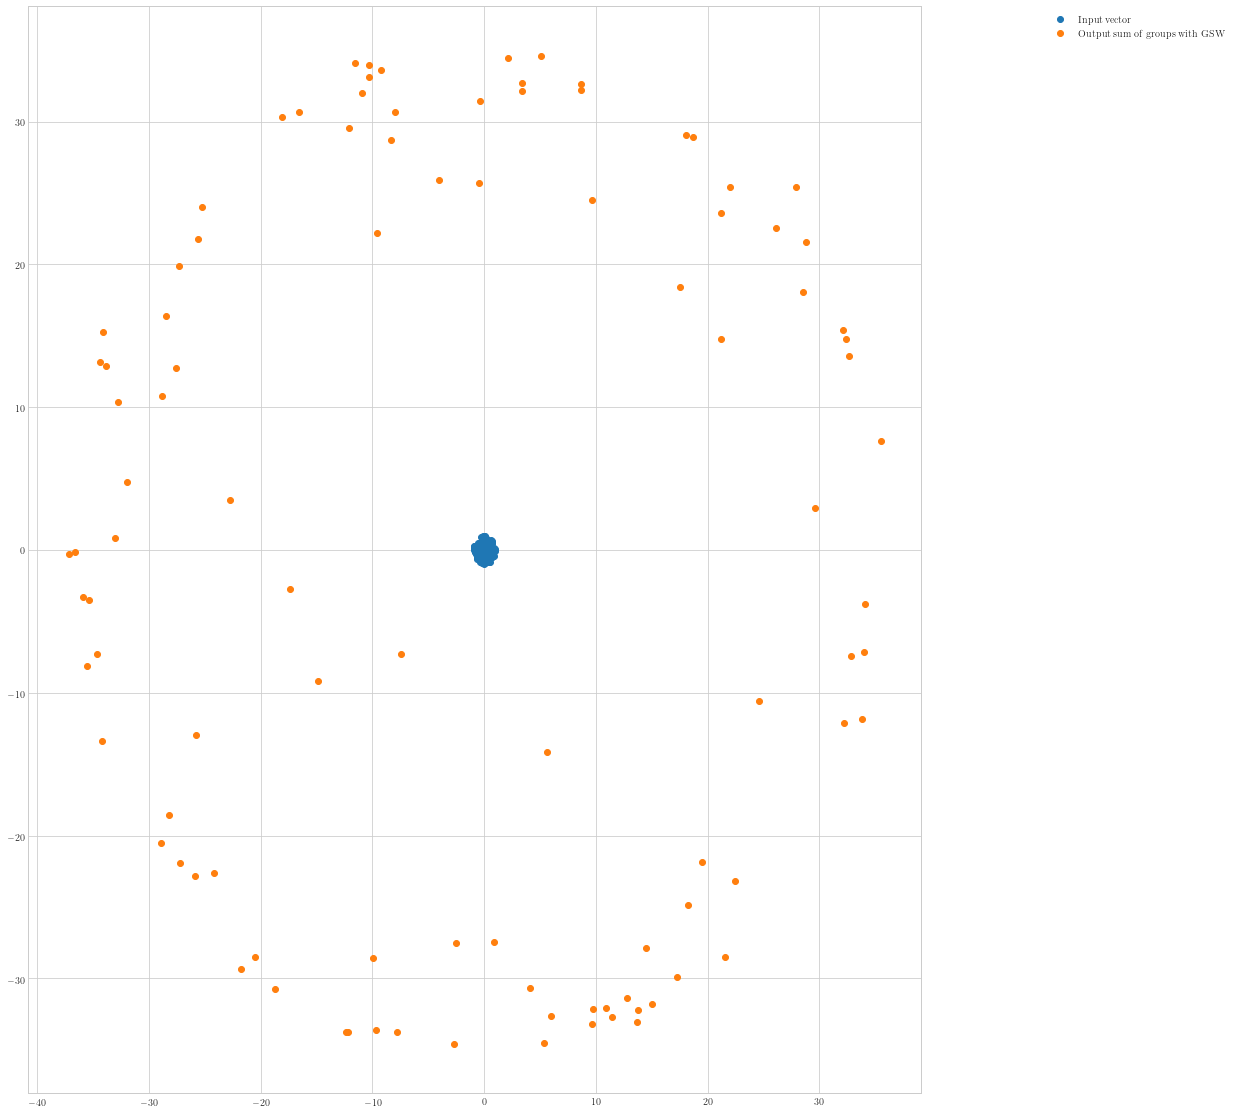

In [5]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

[]


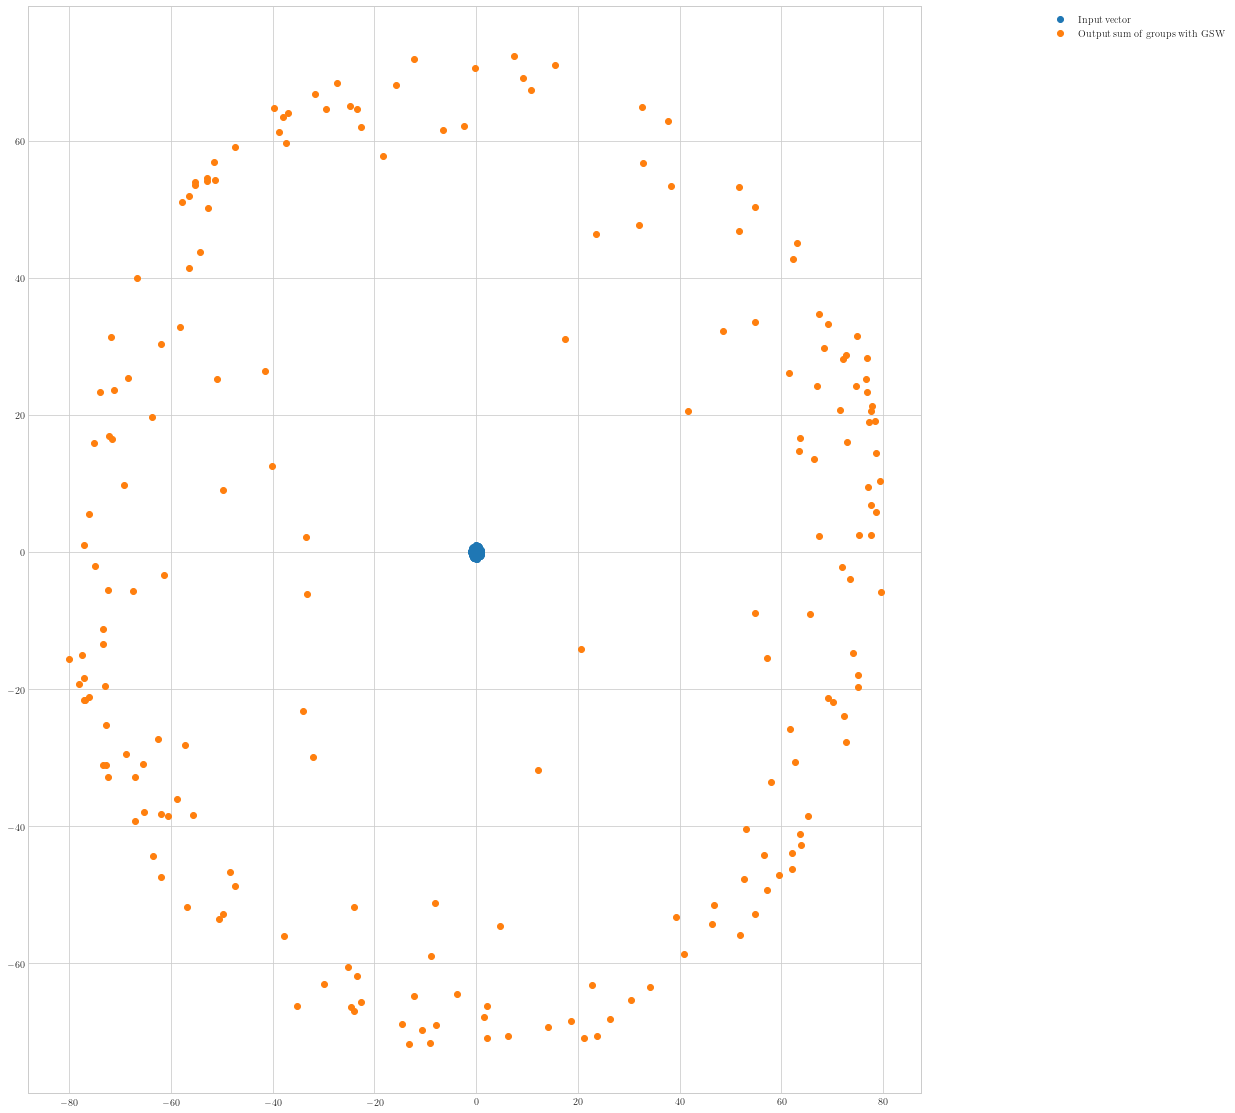

In [4]:
n=200
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")

[]


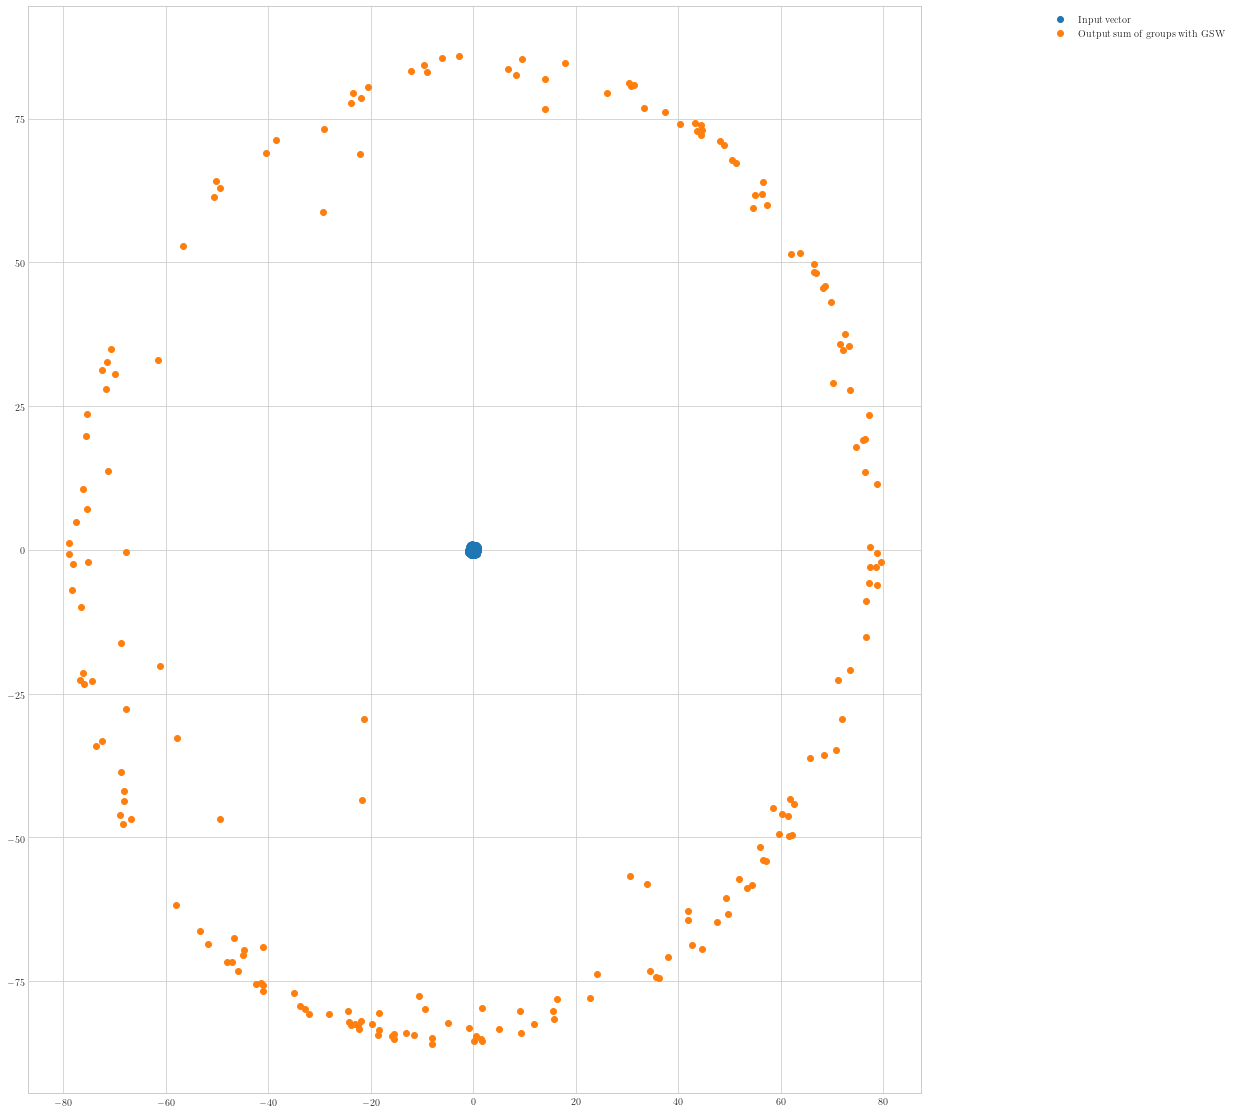

In [5]:
n=200
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,smallest_delta=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

In [ ]:
#Try without -B[:,p] and see if it changes somthing

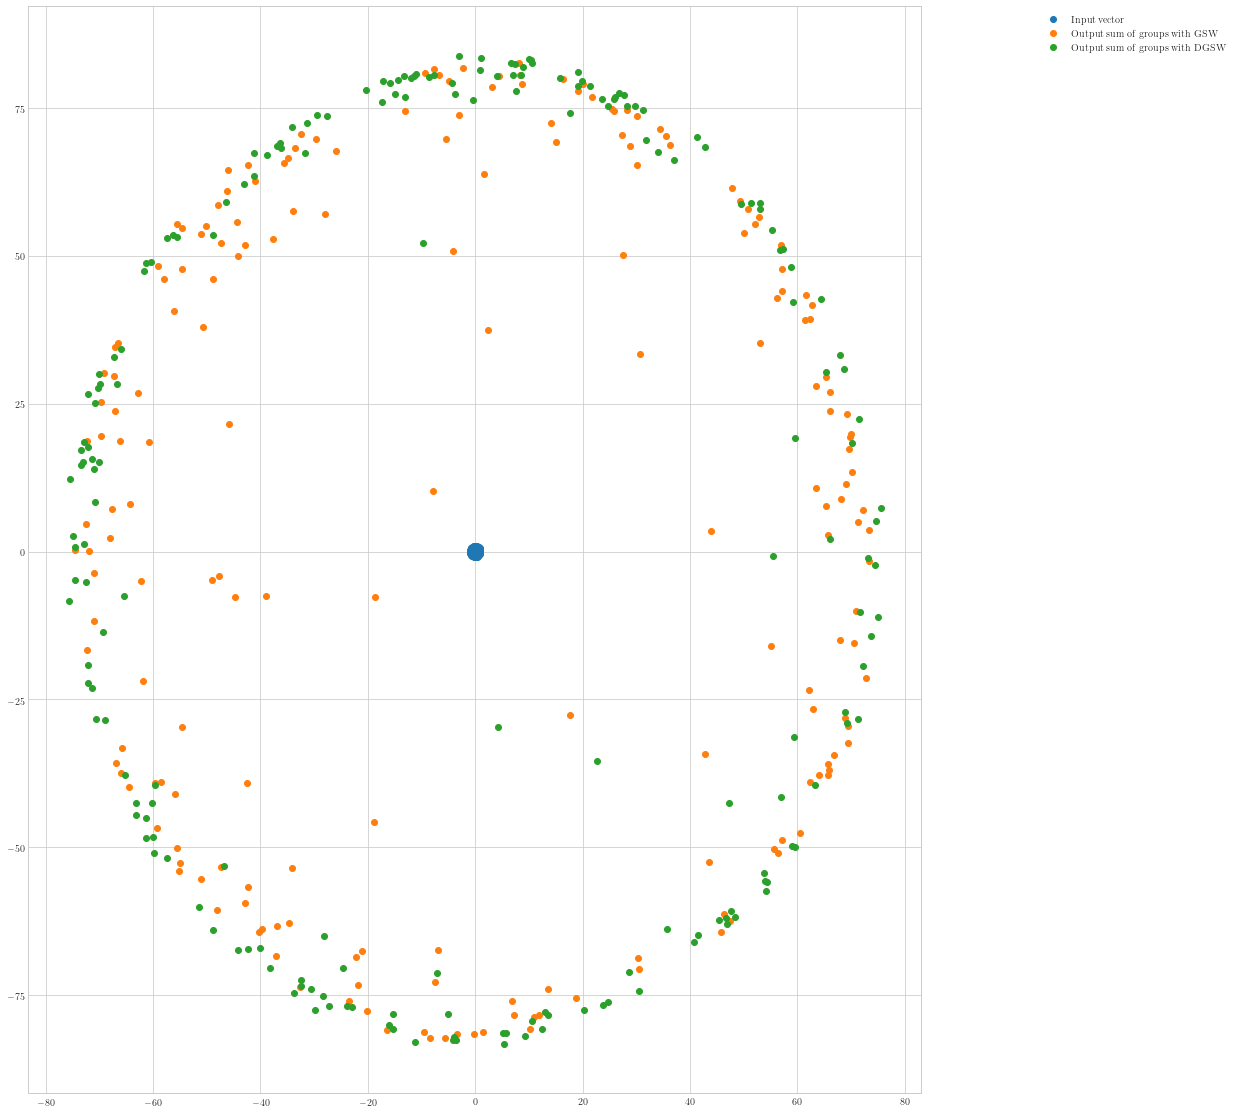

In [3]:
n=200
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=False,smallest_delta=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with DGSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"A_T_instead_of_lstsq_{n}.tex")

In [11]:
max_power=15.0
#max_power=5.0
l=np.logspace(1.0, max_power, num=int(max_power), base=2.0)
n_list=[5,10,20,40,80,160]
#n_list=[5,10]
repeat=10**3
#repeat=10**1
foldername='Using_A_T_instead_of_lstsq_dics/'
#load dics
norms_gsw=open_dic_file(f'{foldername}norms_gsw.pkl')
norms_gsw_det=open_dic_file(f'{foldername}norms_gsw_det.pkl')
norms_naive=open_dic_file(f'{foldername}norms_naive.pkl')
norms_best=open_dic_file(f'{foldername}norms_best.pkl')
plot=0
for n in n_list:
    plot+=1
    print(f'n={n}')
    if norms_gsw.get(n) is None:
        norms_gsw[n]={}
    if norms_gsw_det.get(n) is None:
        norms_gsw_det[n]={}
    if norms_naive.get(n) is None:
        norms_naive[n]={}
    if norms_best.get(n) is None:
        norms_best[n]={}
    for d_ in l:
        d=int(d_)
        print(d)
        if norms_gsw[n].get(d) is None or (n>10 and d>=32):
            norms_gsw[n][d]=[]
        if norms_gsw_det[n].get(d) is None or (n>10 and d>=32):
            norms_gsw_det[n][d]=[]
        if norms_naive[n].get(d) is None or (n>10 and d>=32):
            norms_naive[n][d]=[]
        if norms_best[n].get(d) is None or (n>10 and d>=32):
            norms_best[n][d]=[]
        while min(len(norms_gsw[n][d]),len(norms_gsw_det[n][d]),len(norms_naive[n][d]))<repeat and (len(norms_best[n][d])<repeat or n>10):
            #print(len(norms_gsw[n][d]),len(norms_gsw_det[n][d]),len(norms_naive[n][d]),len(norms_best[n][d]))
            v=sample_from_ball(n,d=d)
            B=np.transpose(np.vstack(tuple([e for e in v])))
            if len(norms_gsw[n][d])<repeat:
                x=gram_schmidt_walk(v,np.zeros(n))
                norms_gsw[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
            if len(norms_gsw_det[n][d])<repeat:
                x_det=gram_schmidt_walk(v,np.zeros(n),smallest_delta=True)
                norms_gsw_det[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_det)])))
            if len(norms_naive[n][d])<repeat:
                x_naive=naive_walk(v,minimizing=False)
                norms_naive[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_naive)])))
            if n<=10 and len(norms_best[n][d])<repeat:
                disc,x_best=best_coloring(v,minimizing=False)
                norms_best[n][d].append(disc)
    plt.subplot(3,2,plot)
    plt.plot(l,[average(norms_gsw[n][d]) for d in l],label=f'GSW')
    plt.plot(l,[average(norms_gsw_det[n][d]) for d in l],label=f'Deterministic GSW')
    plt.plot(l,[average(norms_naive[n][d]) for d in l],label=f'Naive Walk')
    if n<=10:
        plt.plot(l,[average(norms_best[n][d]) for d in l],label=f'Highest Discrepancy Assignment')
    plt.title(f'n = {n} vectors')
    plt.xlabel('Dimension of the vectors')
    plt.ylabel(f'Average norm over {repeat} runs')
    if n==5:
        plt.legend()
    plt.xscale('log')
plt.savefig(f'{foldername}comparative_norms_n={n_list}_repeat={repeat}_max_dim={2**max_power}.pdf')
tikzplotlib.save(f"{foldername}comparative_norms_n={n}_repeat={repeat}_max_dim={2**max_power}.tex")
plt.show()

n=5
2
4
8
16
32
64
128
256
512
1024


KeyboardInterrupt: 

In [10]:
#save dics
save_dic_to_file(norms_gsw,f'{foldername}norms_gsw.pkl')
save_dic_to_file(norms_gsw_det,f'{foldername}norms_gsw_det.pkl')
save_dic_to_file(norms_naive,f'{foldername}norms_naive.pkl')
save_dic_to_file(norms_best,f'{foldername}norms_best.pkl')